<a href="https://colab.research.google.com/github/Dagobert42/WinProbabilityModel-AoE2/blob/main/WinProbabilityModel_AoE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Non-Linear Win Probability Model for Age of Empires II

- Age of Empires II ["AoE2"] is a real-time strategy game set in the middle-ages
- players build a base and command units with the goal of defeating each other 

**Hypothesis:** map and civilisation have non-linear influence on the initial win probabilities of a match

**Idea:** compare predictive power of linear and non-linear models

This project conforms to Microsoft's [Game Content Usage Rules](https://www.xbox.com/en-us/developers/rules).

## 1. Introduction

- players are rated in Elo-system (similar to Chess)
- ratings can be converted directly into probability distributions for the outcome of a match between players A and B by:

$$wp_{A} = \frac{1}{1+10 ^{(r_{A} - r_{B}) / t)}}$$

cite wikipedia

In [1]:
TRANSFER = 200
def elo_to_win_prob(r_player, r_opponent):
    return 1 / ( 1 + 10**((r_opponent - r_player) / TRANSFER))

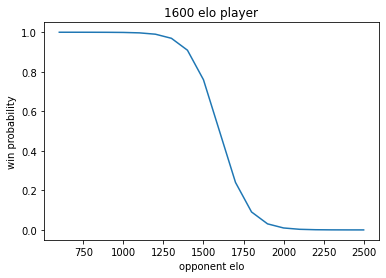

In [2]:
import matplotlib.pyplot as plt

player = 1600
opponents = range(600, 2600, 100)
probs = []
for o in opponents:
    probs.append(elo_to_win_prob(player, float(o)))
plt.plot(opponents, probs)
plt.ylabel('win probability')
plt.xlabel('opponent elo')
plt.title('1600 elo player')
plt.show()

## 2. Data Preprocessing

The following section is included for purposes of the presentation. 

Preprocessing has **already been done** and the resulting csv is provided from the corresponding github repository.

In [3]:
# dependencies
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from IPython.display import clear_output

### 1.1 Processing **matches**

-   limit to 1v1 matches
-   pick a patch (balance changes occur with patches)
-   drop unneeded columns

In [4]:
matches = pd.read_csv('matches.csv')

matches = matches.loc[matches['ladder'] == 'RM_1v1']
matches['patch'].value_counts()

37906    430742
39515    261010
36906    249256
36202    242339
43210    237932
40220    222052
40874    202466
41855    196138
35584     97815
39284      5936
37650      4909
42848      2067
Name: patch, dtype: int64

In [5]:
matches = matches.loc[matches['patch'] == 43210] # most recent patch
matches = matches.drop(columns=['patch', 'ladder', 'mirror', 'average_rating', 'map_size', 'num_players', 'server', 'duration'])
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237932 entries, 44 to 3153755
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   token         237932 non-null  object
 1   winning_team  237932 non-null  int64 
 2   map           237932 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.3+ MB


### 1.2 Processing **players**

- remove players with invalid team value (-1)
- remove matches with invalid teams
- keep only players that were in matches
- drop unneeded columns

In [6]:
players = pd.read_csv('match_players.csv')

invalid_team_players = players.loc[players['team'] == -1]
matches = matches.loc[~matches['token'].isin(invalid_team_players['match'])]

players = players.loc[players['match'].isin(matches['token'])]
players = players.drop(columns=['token', 'color', 'winner'])
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475206 entries, 28 to 9732493
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   match   475206 non-null  object 
 1   rating  463297 non-null  float64
 2   civ     475206 non-null  object 
 3   team    475206 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 18.1+ MB


### 1.3 Merging

- merge matches and players into one dataframe
- exclude players with invalid team (encodes the winner)

This took a very long time (about 3 hours).

In [7]:
try:
    # magic load from repo
    matches_1v1 = pd.read_csv('matches_1v1.csv')
except:
    matches_1v1 = pd.DataFrame(columns=['match_id', 'map', 'rating_p1', 'civ_p1', 'rating_p2', 'civ_p2'])

    player_dict = players.to_dict('records')

    for match in tqdm(matches.to_dict('records')):
        p1 = None
        p2 = None
        for i, player in enumerate(player_dict):
            if player['match'] == match['token']:
                if player['team'] == 1:
                    p1 = player
                    p1_i = i
                elif player['team'] == 2:
                    p2 = player
                    p2_i = i
            # remove already assigned players
            # increase speed gradually
            # Question: actually faster?
            if p1 and p2:
                if p1_i < p2_i:
                    player_dict.pop(p2_i)
                    player_dict.pop(p1_i)
                else:
                    player_dict.pop(p1_i)
                    player_dict.pop(p2_i)
                break

        entry = {
            'match_id' : match['token'],
            'map' : match['map'],
            'rating_p1' : p1['rating'],
            'civ_p1' : p1['civ'],
            'rating_p2' : p2['rating'],
            'civ_p2' : p2['civ'],
            'winner' : match['winning_team']
        }
        matches_1v1 = matches_1v1.append(entry, ignore_index=True)
    
    # save the result
    matches_1v1.to_csv('matches_1v1.csv')

KeyboardInterrupt: ignored

**Question for later:** Is deleting players faster in Big O?

$O(\sum_{i=1}^{m} n-2i)$
$= O(n-2 + n-4 + ... + n-2m)$

Which would still be
$O(m*n)$ ?

Or would it be $O(n)$ since $m = 2n$?


In [ ]:
matches_1v1.info()
matches_1v1.head()

### 1.4 Treating NaN-values (KNN)

**Problem:** some ratings are missing

In [ ]:
nan_rated_players = players.loc[players['rating'].isna()]
nan_rated_players.info()

Check if any match has 2 NaN rated players.

In [ ]:
affected_matches = matches_1v1.loc[matches_1v1['match_id'].isin(nan_rated_players['match'])]
affected_matches['match_id'].value_counts()[:5]

**Option:** simply omit NaN rated players and affected matches (not chosen)

In [ ]:
valid_matches = matches_1v1.loc[~matches_1v1['match_id'].isin(affected_matches['match_id'])]
valid_matches.info()

**Solution:** estimate NaN ratings with k-nearest-neighbor

In [ ]:
import time
from sklearn.neighbors import KNeighborsRegressor as KNR

matches_knr = valid_matches.sample(1000)
nan_knr = KNR(n_neighbors=5, weights="distance")

# order of p1 and p2 is arbitrary for training
X = matches_knr['rating_p1'].to_numpy()
X = np.expand_dims(X, axis=1)
y = matches_knr['rating_p2'].to_numpy()
nan_knr.fit(X,y)

for _, m in affected_matches.iterrows():
    if pd.isnull(m['rating_p1']):
        m['rating_p1'] = round(nan_knr.predict(np.array(m['rating_p2']).reshape(1, -1))[0])
    else:
        m['rating_p2'] = round(nan_knr.predict(np.array(m['rating_p1']).reshape(1, -1))[0])
    valid_matches = valid_matches.append(m)

# save the result
valid_matches.to_csv('augmented_1v1.csv')
valid_matches.info()
valid_matches.head()

Since KNR uses interpolation we overestimate low ratings and underestimate high ratings. 

To solve this we could normalize first over an incomplete dataset.

### 1.5 Normalization (Z-Score)

**Problem:** ratings are distributed asymmetrically

In [ ]:
all_ratings = matches_1v1['rating_p1'].append(matches_1v1['rating_p2'])
n, bins, patches = plt.hist(x=all_ratings, bins=30, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating Ranges')
plt.ylabel('Players')
plt.title('Rating Distribution')
plt.show()

In [ ]:
print('rating skew:', all_ratings.skew())

**Solution:** normalize ratings considering uneven distribution (z-score)